In [550]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

#import
df = pd.read_csv("KaggleV2-May-2016.csv")

# Remove duplicate rows
df = df.drop_duplicates()

# Convert date columns & normalizes scheduled day
date_cols = ["ScheduledDay", "AppointmentDay"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce").dt.normalize()

# Handle missing values

# Drop rows missing critical information
df = df.dropna(subset=["ScheduledDay", "AppointmentDay", "PatientId"])

#Fill missing values for demographics & make sure values make sense
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Age"] = df["Age"].apply(lambda x: 0 if x<0 else x)
df["Gender"] = df["Gender"].fillna("Unknown")

#time between scheduling & appointment
df["Days_Wait"] = (df["AppointmentDay"] - df["ScheduledDay"]).dt.days
df["Days_Wait"] = df["Days_Wait"].apply(lambda x: 0 if x<0 else x)

# Create new feature for if the reminder was sent
df["Reminder"] = df["SMS_received"].apply(lambda x: "Yes" if x == 1 else "No")

#Create new feature for if the person is a scholarship recipent
df["Aid"] = df["Scholarship"].apply(lambda x: "Yes" if x==1 else "No")

#Create new feature  for the weekday
df["Weekday"] = df["AppointmentDay"].dt.day_name()

#Create new feature for if they have a condition
df["Condition"] = (df["Hipertension"] + df["Diabetes"] +df["Alcoholism"] +df["Handcap"]).apply(lambda x: "Yes" if x>0 else "No")

# Normalize the no-show column
df["No-show"] = df["No-show"].str.upper().map({"YES": 1, "NO": 0})

#filter out appointments made on the same day
df = df[df["Days_Wait"]>0]

In [551]:
print("\n===== PROBABILITY ANALYSIS =====")

prob_NoShow = df["No-show"].mean()
print("\nProbability of No-Show")
print(prob_NoShow)

# Create age groups
df["Age_Group"] = pd.cut(df["Age"], bins=[-1, 0, 12, 19, 35, 50, 65, 120],
                         labels=["Infant", "Child", "Teen", "Young Adult", "Adult", "Middle Age", "Senior"])

#Create day groups
df["Days_Group"] = pd.cut(df["Days_Wait"], bins = [0, 7, 14, 28, 56, 84, 168, 200], 
                          labels = ["Week", "2 Weeks", "Month", "2 Month", "3 Month", "6 Months", "Over 6 Months"])

#gets probabilities for each category
prob_age_group = df.groupby("Age_Group", observed=False)["No-show"].mean()
prob_weekday = df.groupby("Weekday", observed=False)["No-show"].mean()
prob_days_group = df.groupby("Days_Group", observed=False)["No-show"].mean()
prob_condition = df.groupby("Condition", observed=False)["No-show"].mean()
prob_reminder = df.groupby("Reminder")["No-show"].mean()
prob_aid = df.groupby("Aid")["No-show"].mean()

print("\nProbability of No-Show by Age Group:")
print(prob_age_group)

print("\nProbability of No-Show by Weekday:")
print(prob_weekday)

print("\nProbability of No-Show by Days Waiting:")
print(prob_days_group)

print("\nProbability of No-Show by underlying Condition")
print(prob_condition)

print("\nProbability of No-Show by Reminder:")
print(prob_reminder)

print("\nProbability of No-Show by Scholarship")
print(prob_aid)

prob_reminder_days_group = df.groupby(["Reminder", "Days_Group"], observed=False)["No-show"].mean()
print("\nProbability of No-Show by Reminder & Days Waiting:")
print(prob_reminder_days_group)

prob_reminder_age_group = df.groupby(["Reminder", "Age_Group"], observed=False)["No-show"].mean()
print("\nProbability of No-Show by Reminder & Age Group:")
print(prob_reminder_age_group)

prob_reminder_condition = df.groupby(["Reminder", "Condition"], observed=False)["No-show"].mean()
print("\nProbability of No-Show by Reminder & underlying Condition")
print(prob_reminder_condition)

prob_reminder_aid = df.groupby(["Reminder", "Aid"], observed = False)["No-show"].mean()
print("\nProbability of No-Show by Reminder & Scholarship")
print(prob_reminder_aid)

prob_day_age_group = df.groupby(["Days_Group", "Age_Group"], observed=False)["No-show"].mean()
print("\nProbability of No-Show by Days Waiting & Age Group:")
print(prob_day_age_group)

prob_condition_days = df.groupby(["Condition", "Days_Group"], observed=False)["No-show"].mean()
print("\nProbability of No-Show by underlying Condition & Days Waiting:")
print(prob_condition_days)

prob_aid_days = df.groupby(["Aid", "Days_Group"], observed=False)["No-show"].mean()
print("\nProbability of No-Show by Scholarship & Days Waiting:")
print(prob_aid_days)

prob_condition_age = df.groupby(["Condition", "Age_Group"], observed=False)["No-show"].mean()
print("\nProbability of No-Show by underlying Condition & Age Group:")
print(prob_condition_age)

prob_aid_age = df.groupby(["Aid", "Age_Group"], observed=False)["No-show"].mean()
print("\nProbability of No-Show by Scholarship & Age Group:")
print(prob_aid_age)

prob_condition_aid = df.groupby(["Condition", "Aid"], observed=False)["No-show"].mean()
print("\nProbability of No-Show by underlying Condition & Scholarship:")
print(prob_condition_aid)


===== PROBABILITY ANALYSIS =====

Probability of No-Show
0.285190177740102

Probability of No-Show by Age Group:
Age_Group
Infant         0.275927
Child          0.316474
Teen           0.365650
Young Adult    0.340864
Adult          0.291414
Middle Age     0.223266
Senior         0.208928
Name: No-show, dtype: float64

Probability of No-Show by Weekday:
Weekday
Friday       0.293544
Monday       0.302105
Saturday     0.290323
Thursday     0.272671
Tuesday      0.286660
Wednesday    0.271474
Name: No-show, dtype: float64

Probability of No-Show by Days Waiting:
Days_Group
Week             0.241479
2 Weeks          0.304699
Month            0.328540
2 Month          0.333333
3 Month          0.303478
6 Months         0.261261
Over 6 Months    0.264706
Name: No-show, dtype: float64

Probability of No-Show by underlying Condition
Condition
No     0.297354
Yes    0.247792
Name: No-show, dtype: float64

Probability of No-Show by Reminder:
Reminder
No     0.294377
Yes    0.275745
Name: No-s

In [554]:
print("\n===== CHI-SQUARE TESTS =====")

def run_chi_square(col):
    table = pd.crosstab(df[col], df["No-show"])
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"\nChi-Square Test: {col}")
    print("p-value:", p)
    print("Significant?" , "YES" if p < 0.05 else "NO")

# Test major categorical factors
for col in ["Gender", "Reminder", "Weekday", "Age_Group", "Days_Group", "Condition", "Aid"]:
    run_chi_square(col)


===== CHI-SQUARE TESTS =====

Chi-Square Test: Gender
p-value: 0.5441949418015478
Significant? NO

Chi-Square Test: Reminder
p-value: 3.275027505140042e-08
Significant? YES

Chi-Square Test: Weekday
p-value: 1.868506115060262e-09
Significant? YES

Chi-Square Test: Age_Group
p-value: 2.1741085964319023e-215
Significant? YES

Chi-Square Test: Days_Group
p-value: 1.38648025388701e-122
Significant? YES

Chi-Square Test: Condition
p-value: 9.59109831975321e-37
Significant? YES

Chi-Square Test: Aid
p-value: 1.8668391497611706e-34
Significant? YES


In [556]:
print("\n===== FINAL SUMMARY TABLE =====")

summary = pd.DataFrame({
    "Metric": ["Overall No-Show Rate",
               "Highest Risk Age Group",
               "Lowest Risk Age Group",
               "Highest Risk Days Waiting",
               "Lowest Risk Age Group",
               "Effect of Reminders",
               "Effect of Scholarship",
               "Day With Highest No-Show Rate",
               "Day with the Lowest No-Show Rate"],
    
    "Value": [
        round(df["No-show"].mean(), 3),
        prob_age_group.idxmax(),
        prob_age_group.idxmin(),
        prob_days_group.idxmax(),
        prob_days_group.idxmin(),
        f"Reminder NO → {round(prob_reminder['No'], 3)}, Reminder YES → {round(prob_reminder['Yes'], 3)}",
        f"NO → {round(prob_aid['No'], 3)}, YES → {round(prob_aid['Yes'], 3)}",
        prob_weekday.idxmax(),
        prob_weekday.idxmin()
    ]
})

print(summary)



===== FINAL SUMMARY TABLE =====
                             Metric                                      Value
0              Overall No-Show Rate                                      0.285
1            Highest Risk Age Group                                       Teen
2             Lowest Risk Age Group                                     Senior
3         Highest Risk Days Waiting                                    2 Month
4             Lowest Risk Age Group                                       Week
5               Effect of Reminders  Reminder NO → 0.294, Reminder YES → 0.276
6             Effect of Scholarship                     NO → 0.279, YES → 0.35
7     Day With Highest No-Show Rate                                     Monday
8  Day with the Lowest No-Show Rate                                  Wednesday


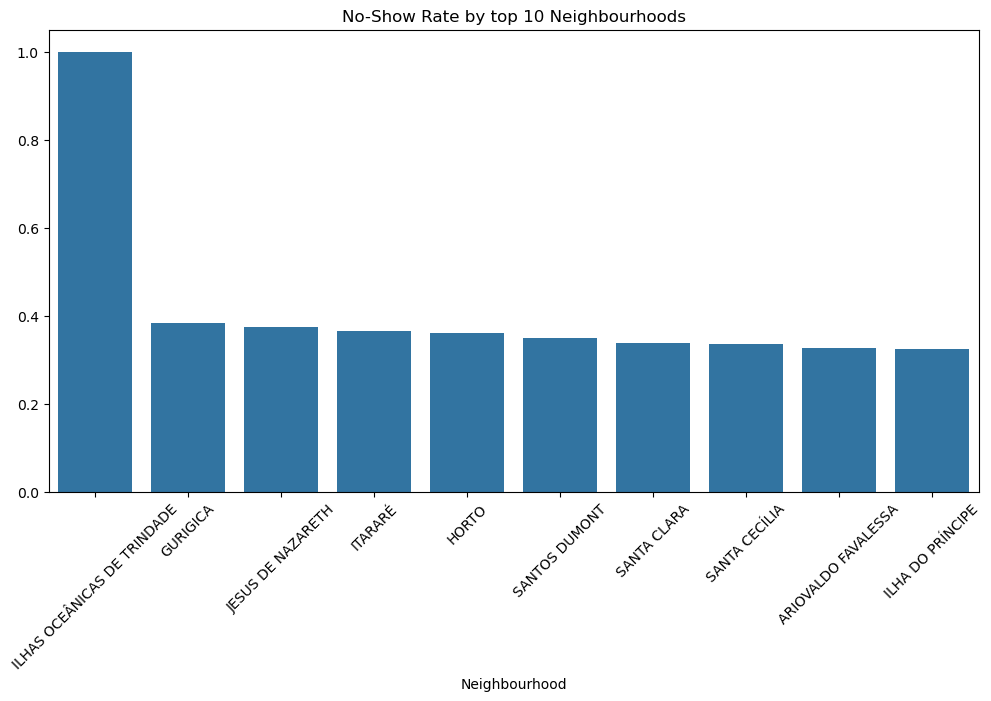

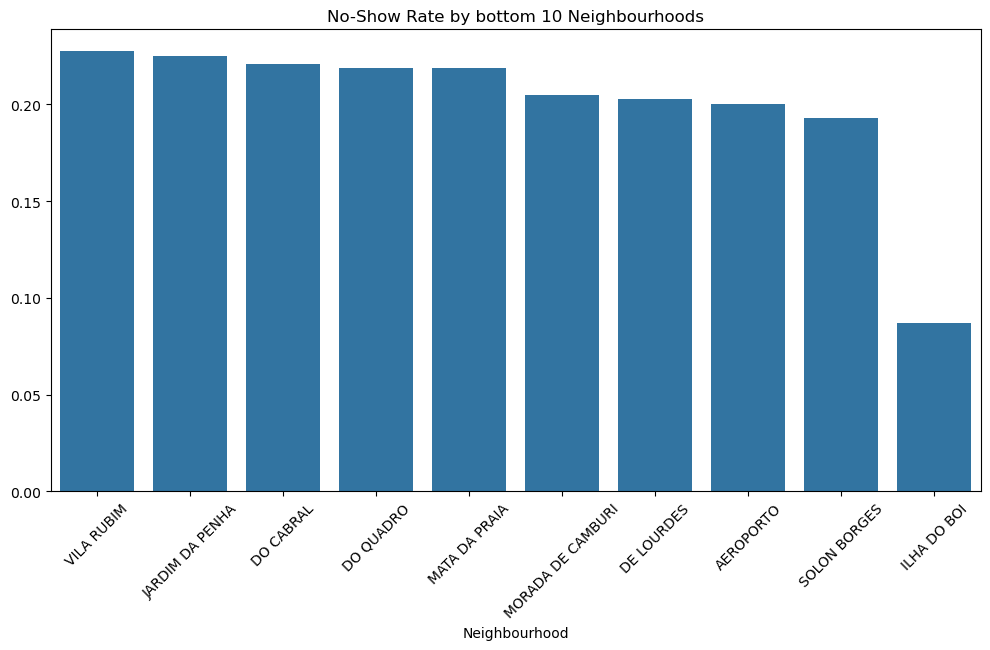

In [559]:
# Plot No-show by Neighborhood
#highest no-show rate
plt.figure(figsize=(12,6))
sns.barplot(x=prob_neighbourhood.index[:10], y=prob_neighbourhood.values[:10])
plt.title("No-Show Rate by top 10 Neighbourhoods")
plt.xticks(rotation=45)
plt.show()

#lowest no-show rate
plt.figure(figsize=(12,6))
sns.barplot(x=prob_neighbourhood.index[-10:], y=prob_neighbourhood.values[-10:])
plt.title("No-Show Rate by bottom 10 Neighbourhoods")
plt.xticks(rotation=45)
plt.show()

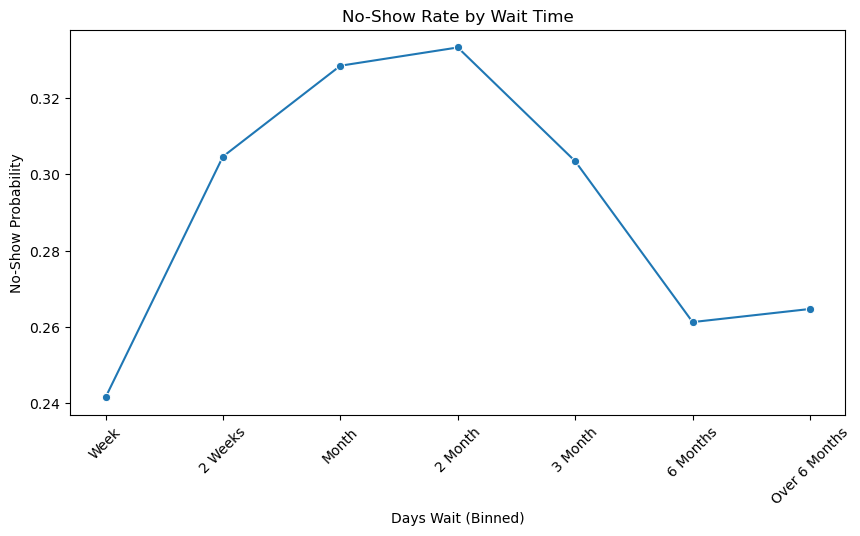

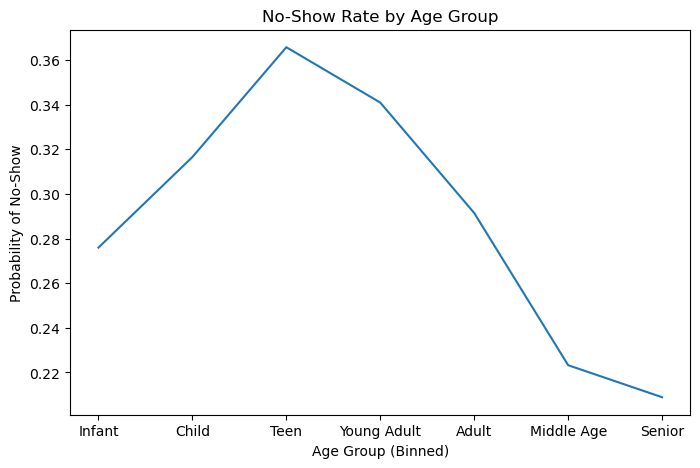

In [560]:
# Wait Time vs No-show probability
plt.figure(figsize=(10,5))
sns.lineplot(x=prob_days_group.index.astype(str), y=prob_days_group.values, marker="o")
plt.title("No-Show Rate by Wait Time")
plt.xlabel("Days Wait (Binned)")
plt.ylabel("No-Show Probability")
plt.xticks(rotation=45)
plt.show()

#Age Group vs No-Show probability
plt.figure(figsize=(8,5))
sns.lineplot(x=prob_age_group.index, y=prob_age_group.values)
plt.title("No-Show Rate by Age Group")
plt.xlabel("Age Group (Binned)")
plt.ylabel("Probability of No-Show")
plt.show()


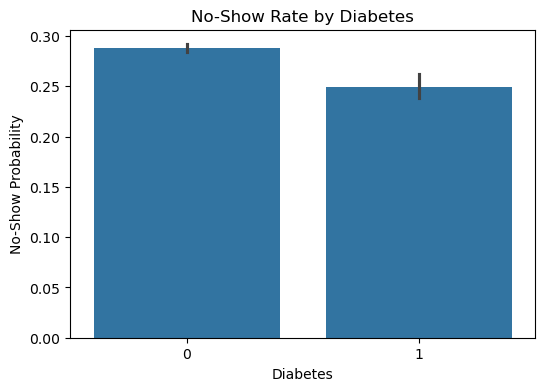

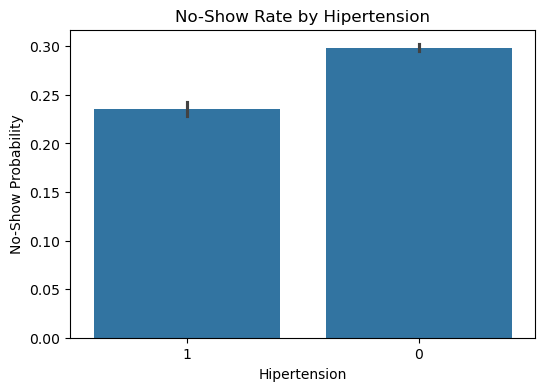

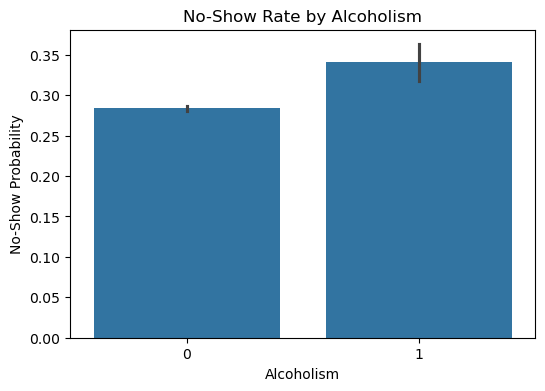

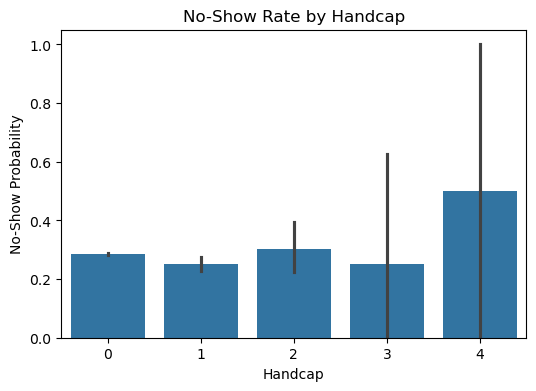

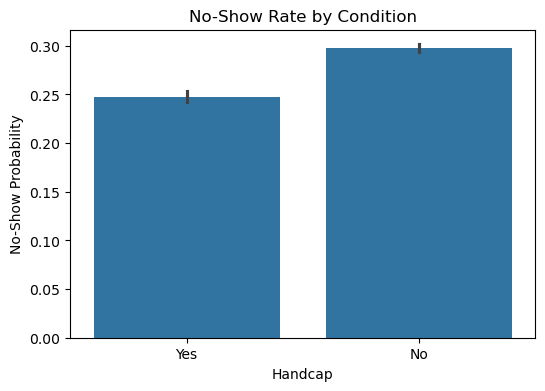

In [561]:
#bar chart for each condition showing the no-show rate

conditions = ["Diabetes", "Hipertension", "Alcoholism", "Handcap"]

for cond in conditions:
    plt.figure(figsize=(6,4))
    sns.barplot(x=df[cond].astype(str), y=df["No-show"])
    plt.title(f"No-Show Rate by {cond}")
    plt.ylabel("No-Show Probability")
    plt.xlabel(cond)
    plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x=df["Condition"], y=df["No-show"])
plt.title("No-Show Rate by Condition")
plt.ylabel("No-Show Probability")
plt.xlabel(cond)
plt.show()

In [562]:
#creates a function to find the probability that someone won't show up given each event
def find_Prob(ageGroup, weekday, daysWait, hasUnderlyingCondition, sentReminder, hasScholarship):
    prob = df[(df['Age_Group'] == ageGroup) & (df['Weekday'] == weekday) & (df['Days_Group'] == daysWait) 
                    & (df['Condition'] == hasUnderlyingCondition) & (df['Reminder'] == sentReminder) 
                    & (df['Aid'] == hasScholarship)]['No-show'].mean()
    return(prob)

print(round(find_Prob('Adult', 'Monday', 'Week', 'Yes', 'No', 'No')*100, 2), "%", sep = '')

31.61%


In [568]:
#calculates the risk score for each category based on the probability they won't show up
df['Risk Score'] = 0
df['Risk Score'] += df['Age_Group'].apply(lambda x: 1 if (x=='Senior') | (x=='Middle Age') else 2 if (x=='Adult') | (x=='Child') | (x=='Infant') else 3)
df['Risk Score'] += df['Days_Group'].apply(lambda x: 1 if (x=='Week') | (x=='6 Months') | (x=='Over 6 Months') else 2 
                                           if (x=='2 Weeks') | (x=='3 Months') else 3)
df['Risk Score'] += df['Reminder'].apply(lambda x: 1 if x=="Yes" else 2)
df['Risk Score'] += df['Condition'].apply(lambda x: 1 if x=="Yes" else 2)
df['Risk Score'] += df['Aid'].apply(lambda x: 1 if x=="No" else 3)
df['Risk Score'] += df['Weekday'].apply(lambda x: 1 if (x=="Thursday") | (x=="Wednesday") else 2)

df['Risk Category'] = df['Risk Score'].apply(lambda x: "Low" if x<9 else "Medium" if x<12 else "High")

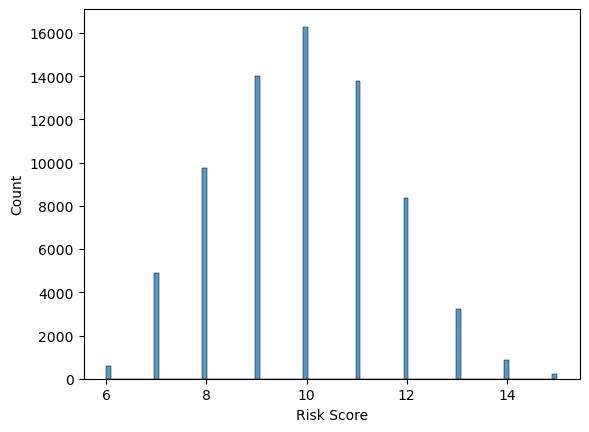

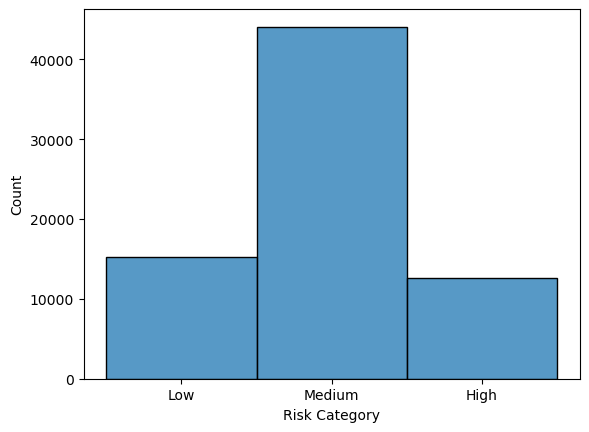

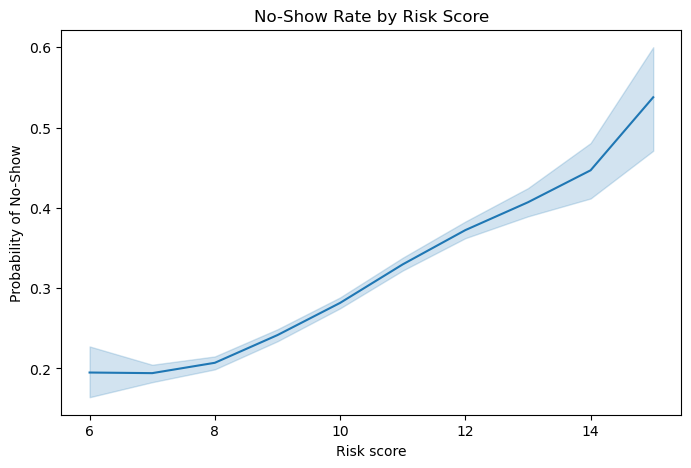

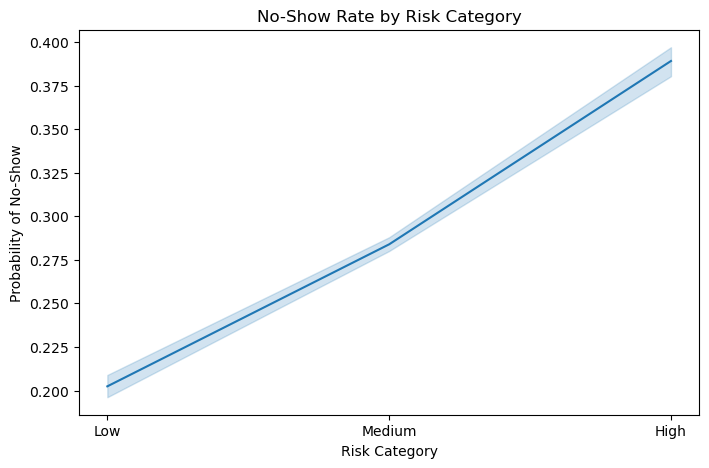

In [570]:
#histograms for risk score & category
sns.histplot(df['Risk Score'])
plt.show()
sns.histplot(df['Risk Category'])
plt.show()

#Risk Score vs No-Show probability
plt.figure(figsize=(8,5))
sns.lineplot(x=df['Risk Score'], y=df['No-show'])
plt.title("No-Show Rate by Risk Score")
plt.xlabel("Risk score")
plt.ylabel("Probability of No-Show")
plt.show()

#Risk Score vs No-Show probability
plt.figure(figsize=(8,5))
sns.lineplot(x=df['Risk Category'], y=df['No-show'])
plt.title("No-Show Rate by Risk Category")
plt.xlabel("Risk Category")
plt.ylabel("Probability of No-Show")
plt.show()

In [571]:
#shows the probability that each category won't show up
df.groupby('Risk Category')['No-show'].mean()

Risk Category
High      0.389121
Low       0.202393
Medium    0.283899
Name: No-show, dtype: float64

In [544]:
#adds the cleaned data to a new excel file
df.to_csv('Medical_Appointments_Cleaned.csv', index=False)